In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy
import numpy as np
import torch
import matplotlib.pyplot as plt
import pdb
from neurosim.models.varma import gen_var1_connectivity
from neurosim.models.ssr import StateSpaceRealization as SSR
from neurosim.models.ssr import memoized

In [4]:
from dca.dca import DynamicalComponentsAnalysis as DCA
import collections
from dca.dca import init_coef, ObjectiveWrapper, ortho_reg_fn
from scipy.optimize import minimize
from dca.cov_util import calc_pi_from_data

In [5]:
from pseudopy.nonnormal import NonnormalAuto, NonnormalPoints

In [6]:
from neurosim.models.subspaces import residue_calc
from neurosim.models.subspaces import measure_angle

In [7]:
import pickle
import h5py

In [9]:
f = h5py.File('/media/akumar/Data/nse/data/neuraldata/EC2_hg.h5', 'r')

In [27]:
f['X']

<HDF5 dataset "X": shape (2576, 258, 86, 1), type "<f4">

In [18]:
f['y'][:]

array([b'raa', b'shee', b'yoo', ..., b'kaa', b'waa', b'daa'], dtype='|S4')

In [ ]:
# Count how many of each category there are

In [12]:
# Use logistic regression to classify f['y'] (the particular syllable) using f['X']
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [ ]:
# No normalization for now
# X = np.squeeze(f['X'])
# scaler = StandardScaler()
# Xstd = np.zeros(X.shape)
# for i in range(X.shape[0]):
#     for j in range(X.shape[2])
#     Xstd[i, :, j] = scaler.fit_transform(X[i, :, j])

In [13]:
classifier = LogisticRegression()

In [38]:
X = np.squeeze(f['X'])
y = np.array(f['y'])

In [41]:
syllable_counts = {}
n_folds = 10
cv = StratifiedKFold(n_folds, shuffle=False, random_state=1234)

# Initialize keys
for elem in np.unique(y):
    syllable_counts[elem] = np.zeros(n_folds)

fold_idx = 0
for train_idxs, test_idxs in cv.split(X, y):
    yy = y[train_idxs]
    
    for elem in yy:
        syllable_counts[elem][fold_idx] += 1
        
    fold_idx += 1

In [42]:
syllable_counts

{b'baa': array([41., 41., 41., 40., 40., 40., 40., 40., 41., 41.]),
 b'bee': array([41., 41., 41., 41., 42., 42., 42., 42., 41., 41.]),
 b'boo': array([31., 31., 30., 30., 30., 30., 31., 31., 31., 31.]),
 b'daa': array([39., 40., 40., 40., 40., 40., 40., 39., 39., 39.]),
 b'dee': array([40., 40., 40., 39., 39., 39., 39., 40., 40., 40.]),
 b'doo': array([43., 43., 43., 44., 44., 43., 43., 43., 43., 43.]),
 b'faa': array([42., 41., 41., 41., 41., 41., 41., 42., 42., 42.]),
 b'fee': array([41., 41., 41., 41., 41., 40., 40., 40., 40., 40.]),
 b'foo': array([40., 40., 40., 39., 39., 39., 39., 40., 40., 40.]),
 b'gaa': array([40., 40., 40., 40., 39., 39., 39., 39., 40., 40.]),
 b'gee': array([39., 39., 39., 39., 38., 38., 38., 39., 39., 39.]),
 b'goo': array([39., 40., 40., 40., 40., 40., 40., 39., 39., 39.]),
 b'haa': array([44., 44., 44., 44., 44., 44., 44., 44., 44., 45.]),
 b'hee': array([45., 45., 45., 45., 45., 45., 45., 45., 45., 45.]),
 b'hoo': array([41., 42., 42., 42., 42., 41., 41

In [50]:
y.size

2576

In [49]:
np.where(y != b'thee')[0].size

2566

In [51]:
# Remove 'thee'
theeless = np.where(y != b'thee')[0]
X = X[theeless, ...]
y = y[theeless]

In [52]:
cv = StratifiedKFold(10, shuffle=False, random_state=1234)
scores = []
for train_idxs, test_idxs in cv.split(X, y):
    xx = np.reshape(X[train_idxs, ...], (train_idxs.size, -1))
    yy = y[train_idxs]

    
    
#     scaler = StandardScaler()
#     xx = scaler.fit_transform(xx)
    
    classifier.fit(xx, yy)
    scores.append(classifier.score(np.reshape(X[test_idxs, ...], (test_idxs.size, -1)), y[test_idxs]))

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1

In [54]:
np.mean(scores)

0.40727444066147866

In [53]:
scores

[0.40077821011673154,
 0.4357976653696498,
 0.36186770428015563,
 0.3540856031128405,
 0.42412451361867703,
 0.40077821011673154,
 0.44921875,
 0.37109375,
 0.3828125,
 0.4921875]

In [31]:
classifier.classes_

array([b'baa', b'bee', b'boo', b'daa', b'dee', b'doo', b'faa', b'fee',
       b'foo', b'gaa', b'gee', b'goo', b'haa', b'hee', b'hoo', b'kaa',
       b'kee', b'koo', b'laa', b'lee', b'loo', b'maa', b'mee', b'moo',
       b'naa', b'nee', b'noo', b'paa', b'pee', b'poo', b'raa', b'ree',
       b'roo', b'saa', b'see', b'shaa', b'shee', b'shoo', b'soo', b'taa',
       b'tee', b'thaa', b'thee', b'thoo', b'too', b'vaa', b'vee', b'voo',
       b'waa', b'wee', b'woo', b'yaa', b'yee', b'yoo', b'zaa', b'zee',
       b'zoo'], dtype='|S4')

In [32]:
classifier.score(np.reshape(np.squeeze(f['X']), (2576, -1)), f['y'])

1.0

In [40]:
size = 20

optimized_pi_vs_dim = np.zeros((size))
ordered_pi_vs_dim = np.zeros((size))
#reverse_order_pi_vs_dim = np.zeros((size))

rand_reps = 200
random_pi_vs_dim = np.zeros((size, rand_reps))

ssm = SSR(A=A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]), D=1e-16 * np.eye(A.shape[0]))
    
X = np.reshape(f['baa'][:, 0:100, :], (-1, 54))

dca_model = DCA()
for j in np.arange(size):
    dca_model.fit(X, T=5, d=j + 1)
    V = dca_model.coef_
    optimized_pi_vs_dim[j] = dca_model.score()
    print('Hello!')


Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!


In [42]:
# Calculate the normal ordered schur components
X = np.reshape(f['baa'][:, 0:100, :], (-1, 54))
A = np.squeeze(cons_coef)
T, Z = schur(A, np.argsort(np.abs(np.linalg.eigvals(A)))[::-1])
for j in np.arange(size):
    V = Z[:, 0:j + 1]
    if V.ndim == 1:
        V = V[:, np.newaxis]

    ordered_pi_vs_dim[j] = calc_pi_from_data(X, T=5, proj=V)

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


In [31]:
from matplotlib.ticker import MaxNLocator

In [41]:
size = 20

optimized_pi_vs_dim2 = np.zeros((size))
ordered_pi_vs_dim2 = np.zeros((size))
#reverse_order_pi_vs_dim = np.zeros((size))

rand_reps = 200
random_pi_vs_dim = np.zeros((size, rand_reps))

ssm = SSR(A=A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]), D=1e-16 * np.eye(A.shape[0]))
    
X = np.reshape(f['baa'][:, 100:, :], (-1, 54))

dca_model = DCA()
for j in np.arange(size):
    dca_model.fit(X, T=5, d=j + 1)
    V = dca_model.coef_
    optimized_pi_vs_dim2[j] = dca_model.score()
    print('Hello!')


Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!


In [43]:
# Calculate the normal ordered schur components
A = np.squeeze(vowel_coef)
X = np.reshape(f['baa'][:, 100:, :], (-1, 54))
T, Z = schur(A, np.argsort(np.abs(np.linalg.eigvals(A)))[::-1])
for j in np.arange(size):
    V = Z[:, 0:j + 1]
    if V.ndim == 1:
        V = V[:, np.newaxis]

    ordered_pi_vs_dim2[j] = calc_pi_from_data(X, T=5, proj=V)

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


In [37]:
ordered_pi_vs_dim2

array([ 2.18185723,  4.28343443,  6.56040759,  8.87925098, 11.06287938,
       13.55453567, 15.67424419, 18.32494847, 20.74745817, 23.27709173,
       25.74052011, 28.35258198, 30.83825064, 33.09657151, 35.45410104,
       38.16852758, 40.74574836, 43.13429567, 45.63413983, 48.13343688])

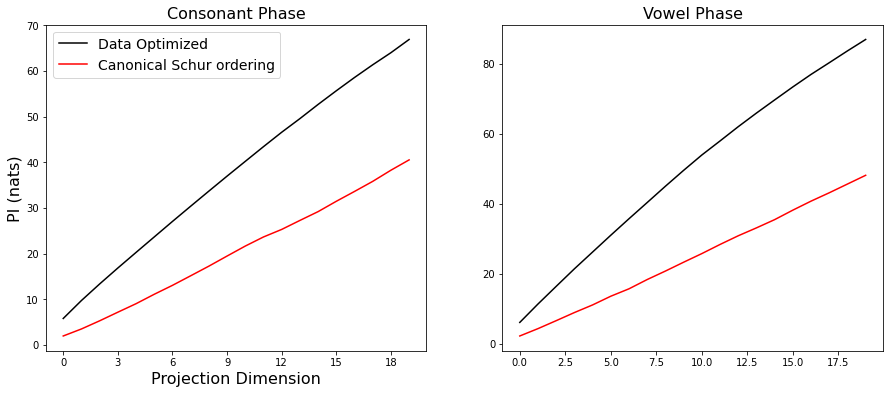

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(optimized_pi_vs_dim, 'k')
ax[0].plot(ordered_pi_vs_dim, 'r')

ax[0].set_title('Consonant Phase', fontsize=16)
ax[0].set_ylabel('PI (nats)', fontsize=16)
ax[0].set_xlabel('Projection Dimension', fontsize=16)
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[0].legend(['Data Optimized', 'Canonical Schur ordering'], fontsize=14)

ax[1].plot(optimized_pi_vs_dim2, 'k')
ax[1].plot(ordered_pi_vs_dim2, 'r')

ax[1].set_title('Vowel Phase', fontsize=16)
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

fig.savefig('cv_schur.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Plot the pseudospectra

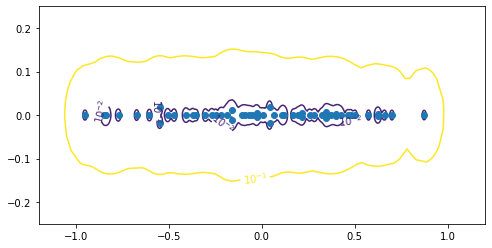

In [53]:
# Take a look the pseudo spectrum
fig, ax = plt.subplots(figsize=(8, 4))
A = np.squeeze(cons_coef)
pseudo = NonnormalAuto(A, 1e-5, 1)
pseudo.plot([10**k for k in range(-4, 0)], spectrum=np.linalg.eigvals(A))
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-0.25, 0.25])
plt.savefig('cv_cons_pseudo.pdf', bbox_inches='tight', pad_inches=0)

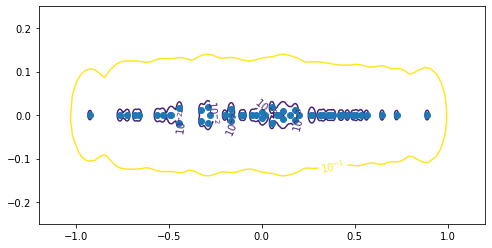

In [55]:
# Take a look the pseudo spectrum
fig, ax = plt.subplots(figsize=(8, 4))
A = np.squeeze(vowel_coef)
pseudo = NonnormalAuto(A, 1e-5, 1)
pseudo.plot([10**k for k in range(-4, 0)], spectrum=np.linalg.eigvals(A))
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-0.25, 0.25])
plt.savefig('cv_vowel_pseudo.pdf', bbox_inches='tight', pad_inches=0)